In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from node2vec import Node2Vec

ModuleNotFoundError: No module named 'node2vec'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.manifold import TSNE

In [3]:
import umap

In [6]:
xcf_edge_data=pd.read_csv('datasets/xcf_ingr_edge.pkl',index_col=0)
xcf_node_data=pd.read_csv('datasets/xcf_ingr_node.pkl',index_col=0)

ars_edge_data=pd.read_csv('datasets/ars_ingr_edge.pkl',index_col=0)
ars_node_data=pd.read_csv('datasets/ars_ingr_node.pkl',index_col=0)

kb_edge_data=pd.read_csv('datasets/kb_ingr_edge.pkl',index_col=0)
kb_node_data=pd.read_csv('datasets/kb_ingr_node.pkl',index_col=0)

xcf_nodelists=list(set(xcf_edge_data['id_1'].values.tolist())|set(xcf_edge_data['id_2'].values.tolist()))
print('There are {} nodes and {} edges in Xiachufang collection'.format(len(xcf_nodelists),xcf_edge_data.shape[0]))

ars_nodelists=list(set(ars_edge_data['id_1'].values.tolist())|set(ars_edge_data['id_2'].values.tolist()))
print('There are {} nodes and {} edges in Allrecipes collection'.format(len(ars_nodelists),ars_edge_data.shape[0]))

kb_nodelists=list(set(kb_edge_data['id_1'].values.tolist())|set(kb_edge_data['id_2'].values.tolist()))
print('There are {} nodes and {} edges in Kochbar collection'.format(len(kb_nodelists),kb_edge_data.shape[0]))

There are 130 nodes and 751 edges in Xiachufang collection
There are 143 nodes and 1144 edges in Allrecipes collection
There are 155 nodes and 1527 edges in Kochbar collection


In [5]:
xcf_node_data.rename(columns={'name':'ingr'},inplace=True)
ars_node_data.rename(columns={'name':'ingr'},inplace=True)
kb_node_data.rename(columns={'name':'ingr'},inplace=True)

In [6]:
def emb_Node2vec(edge_data,walk_length,num_walks,node_data):
    # walk_length: according to the average number of ingredients in the recipes from each collection
    # xcf: 5.5, ars: 8.4, kb: 9.6 (not work,if the length is too short, all nodes will display on a line)
    # num_walks: from the minumum value (threshold 10)
    # suggested num_walks: 32--64, walk_length: 40 steps
    # p=q=0.25
    G=nx.from_pandas_edgelist(edge_data,'id_1','id_2',['npmi','edge_type'])
    model=Node2Vec(G,walk_length=walk_length,num_walks=num_walks,p=2,q=0.25,workers=1)
    model=model.fit(window=5,min_count=1,batch_words=4)
    ingr_list=[]
    embedding_list=[]
    for ingr in model.wv.vocab.keys():
        ingr_list.append(ingr)
        embedding_list.append(model[ingr])
    node2vec_emb=pd.DataFrame({'ingr':ingr_list,'embeddings':embedding_list})
    node2vec_emb=pd.merge(node2vec_emb,node_data,on='ingr')
    node2vec_emb.drop('prevelence',axis=1,inplace=True)
    
    return node2vec_emb

In [7]:
# form mypalette
Mypalette=[]
for i in range(0,12):
    colors=plt.cm.Set3(i)
    Mypalette.append(colors)

In [8]:
Mypalette.append((1.0,1.0,1.0))
Mypalette.append(plt.cm.Paired(11))

In [9]:
def vis_tsne(node2vec_emb_df,column,random_state):
    emb_tsne=TSNE(n_components=2,n_jobs=-1,random_state=random_state).fit_transform(node2vec_emb_df[column].values.tolist())
    emb_tsne_df=pd.concat([pd.Series(emb_tsne[:,0]),pd.Series(emb_tsne[:,1]),node2vec_emb_df['comb_cate']],axis=1)
    emb_tsne_df.rename(columns={0:'x_axis',1:'y_axis'},inplace=True)
    
    color_dict={'Additive/Spice':Mypalette[3],
            'Animal Product':Mypalette[1],
            'Bakery':Mypalette[13],
            'Beverage':Mypalette[0],
            'Cereal/Maize':Mypalette[4],
            'Dairy':Mypalette[12],
            'Dish':Mypalette[6],
            'Fish/Seafood':Mypalette[7],
            'Fruit':Mypalette[8],
            'Fungus':Mypalette[9],
            'Herb':Mypalette[10],
            'Plant/Plant Derivative':Mypalette[11],
            'Seed/Nut/Legume':Mypalette[5],
            'Vegetable':Mypalette[2]      
           }
    fig,ax=plt.subplots(figsize=(8,5))
    sns.scatterplot(x=emb_tsne_df['x_axis'],y=emb_tsne_df['y_axis'],hue=emb_tsne_df['comb_cate'].tolist(),
                palette=color_dict,
                edgecolor='black')
    plt.legend(bbox_to_anchor=(1.05,1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticklabels([])
    return emb_tsne_df

In [35]:
def vis_umap(node2vec_emb_df,column,n_neighbors,min_dist,random_state):
    umap_emb=umap.UMAP(n_neighbors=n_neighbors,
                       min_dist=min_dist,
                       metric='correlation',
                       random_state=random_state).fit_transform(node2vec_emb_df[column].values.tolist())
    umap_emb_df=pd.concat([pd.Series(umap_emb[:,0]),pd.Series(umap_emb[:,1]),node2vec_emb_df['comb_cate']],axis=1)
    umap_emb_df.rename(columns={0:'x_axis',1:'y_axis'},inplace=True)
    
    color_dict={'Additive/Spice':Mypalette[3],
            'Animal Product':Mypalette[1],
            'Bakery':Mypalette[13],
            'Beverage':Mypalette[0],
            'Cereal/Maize':Mypalette[4],
            'Dairy':Mypalette[12],
            'Dish':Mypalette[6],
            'Fish/Seafood':Mypalette[7],
            'Fruit':Mypalette[8],
            'Fungus':Mypalette[9],
            'Herb':Mypalette[10],
            'Plant/Plant Derivative':Mypalette[11],
            'Seed/Nut/Legume':Mypalette[5],
            'Vegetable':Mypalette[2]      
           }
    fig,ax=plt.subplots(figsize=(8,5))
    sns.scatterplot(x=umap_emb_df['x_axis'],y=umap_emb_df['y_axis'],hue=umap_emb_df['comb_cate'].tolist(),
                palette=color_dict,
                edgecolor='black')
    plt.legend(bbox_to_anchor=(1.05,1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticklabels([])
    return umap_emb_df

In [38]:
xcf_node2vec_emb=emb_Node2vec(xcf_edge_data,32,40,xcf_node_data)

Computing transition probabilities:   0%|          | 0/130 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 40/40 [00:04<00:00,  9.84it/s]
/opt/anaconda3/envs/mypython3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [43]:
xcf_node2vec_emb.to_pickle('datasets/xcf_tb_n2v_node.pkl')

/opt/anaconda3/envs/mypython3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,x_axis,y_axis,comb_cate
0,3.250747,0.852282,Fruit
1,4.375456,-0.012419,Cereal/Maize
2,5.682192,0.943340,Plant/Plant Derivative
3,5.843918,1.620653,Fruit
4,4.163343,2.432081,Additive/Spice
...,...,...,...
125,-0.762512,-11.594130,Plant/Plant Derivative
126,-1.029655,-10.485132,Fish/Seafood
127,2.620918,4.058752,Dish
128,-2.812351,-10.921352,Vegetable


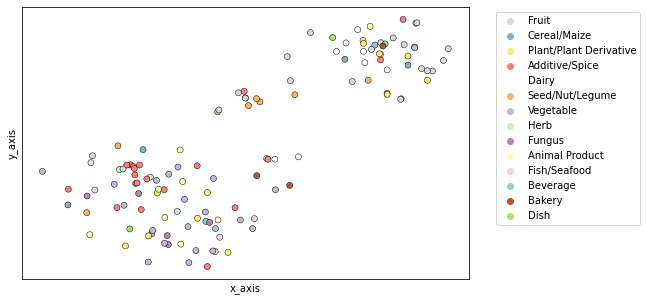

In [11]:
# vis_tsne(xcf_node2vec_emb,'embeddings',1001)

/opt/anaconda3/envs/mypython3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


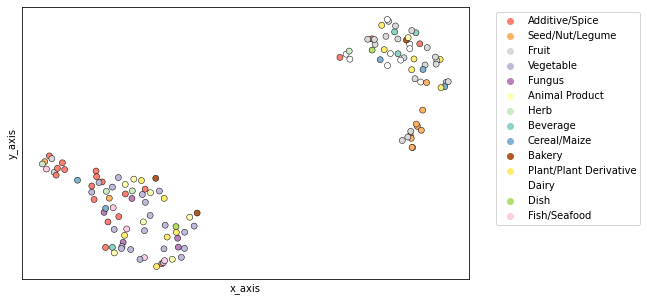

In [42]:
vis_umap(xcf_node2vec_emb,'embeddings',5,0.3,42)
plt.savefig('graphs/pdf/xcf_tb_n2v_umap.pdf',dpi=300,bbox_inches='tight')
plt.savefig('graphs/png/xcf_tb_n2v_umap.png',dpi=300,bbox_inches='tight')

In [46]:
ars_node2vec_emb=emb_Node2vec(ars_edge_data,35,40,ars_node_data)

Computing transition probabilities:   0%|          | 0/143 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 40/40 [00:04<00:00,  8.01it/s]
/opt/anaconda3/envs/mypython3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [50]:
ars_node2vec_emb.to_pickle('datasets/ars_tb_n2v_node.pkl')

/opt/anaconda3/envs/mypython3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


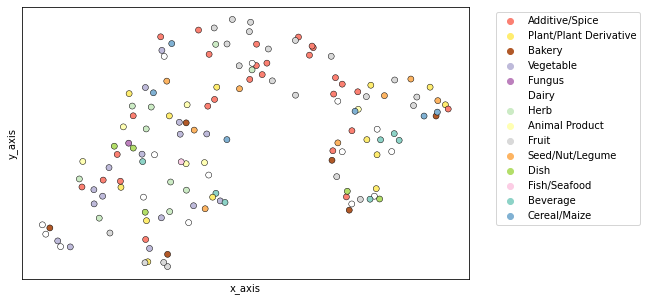

In [49]:
vis_umap(ars_node2vec_emb,'embeddings',5,0.3,9527)
plt.savefig('graphs/pdf/ars_tb_n2v_umap.pdf',dpi=300,bbox_inches='tight')
plt.savefig('graphs/png/ars_tb_n2v_umap.png',dpi=300,bbox_inches='tight')

In [53]:
kb_node2vec_emb=emb_Node2vec(kb_edge_data,32,40,kb_node_data)

Computing transition probabilities:   0%|          | 0/155 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 40/40 [00:05<00:00,  7.90it/s]
/opt/anaconda3/envs/mypython3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [56]:
kb_node2vec_emb.to_pickle('datasets/kb_tb_n2v_node.pkl')

/opt/anaconda3/envs/mypython3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


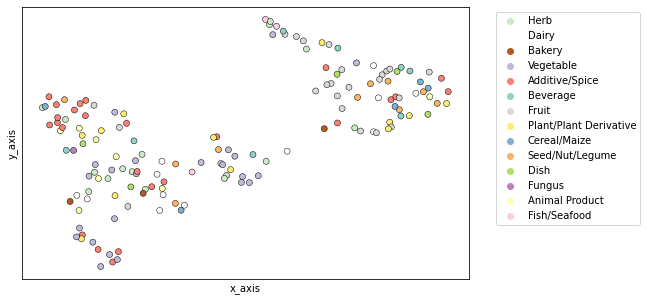

In [55]:
vis_umap(kb_node2vec_emb,'embeddings',5,0.3,9527)
plt.savefig('graphs/pdf/kb_tb_n2v_umap.pdf',dpi=300,bbox_inches='tight')
plt.savefig('graphs/png/kb_tb_n2v_umap.png',dpi=300,bbox_inches='tight')